In [2]:
import os
from glob import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
import monai.networks.nets as nets

In [3]:
from sklearn.model_selection import KFold
from monai.data import Dataset, DataLoader, CacheDataset, NibabelReader
from monai.utils.misc import first, set_determinism
from monai.inferers import sliding_window_inference
from KFoldEnsemble import KFoldEnsemble

In [4]:
from monai.transforms import (
    Compose,
    LoadImaged,
    ToTensord,
    EnsureChannelFirstd,
    Spacingd,
    ScaleIntensityRanged,
    CropForegroundd,
    Resized,
    Orientationd,
    Activations,
    ## Data Augmentation transforms
    #RandRotated,
    #RandFlipd,
    #RandScaleIntensityd,
    #RandShiftIntensityd,
    #RandAdjustContrastd,
    #RandGaussianNoised,
    #OneOf             # OneOf is a MONAI transform that  provides the ability to randomly choose one transform out of a list of callables with pre-defined probabilities for each.
)


In [5]:
# Paths
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_path = 'D:/personal projects/Image segmentation with Pythorch and MONAI/MODEL'
in_path = 'D:/personal projects/Image segmentation with Pythorch and MONAI/Img'

output_img_path = 'D:/personal projects/Image segmentation with Pythorch and MONAI/RESULTS'
#model ensemble instance
ensemble = KFoldEnsemble(
    model_dir = model_path,
    model_name = 'seg_res_net',
    device = device,
    num_folds=5
)
print(f'{len(ensemble)} models loaded ')

Loading model from fold 1: D:/personal projects/Image segmentation with Pythorch and MONAI/MODEL\fold1\best_metric_model.pth
Loading model from fold 2: D:/personal projects/Image segmentation with Pythorch and MONAI/MODEL\fold2\best_metric_model.pth
Loading model from fold 3: D:/personal projects/Image segmentation with Pythorch and MONAI/MODEL\fold3\best_metric_model.pth
Loading model from fold 4: D:/personal projects/Image segmentation with Pythorch and MONAI/MODEL\fold4\best_metric_model.pth
Loading model from fold 5: D:/personal projects/Image segmentation with Pythorch and MONAI/MODEL\fold5\best_metric_model.pth
5 models loaded 


In [6]:
train_losses = []
train_metrics = []
val_losses = []
val_metrics = []
for i in range(1,6):
    train_losses.append(np.load(os.path.join(model_path, f'fold{i}', 'loss_train.npy')))
    train_metrics.append(np.load(os.path.join(model_path, f'fold{i}', 'metric_train.npy')))
    val_losses.append(np.load(os.path.join(model_path, f'fold{i}', 'loss_val.npy')))
    val_metrics.append(np.load(os.path.join(model_path, f'fold{i}', 'metric_val.npy')))

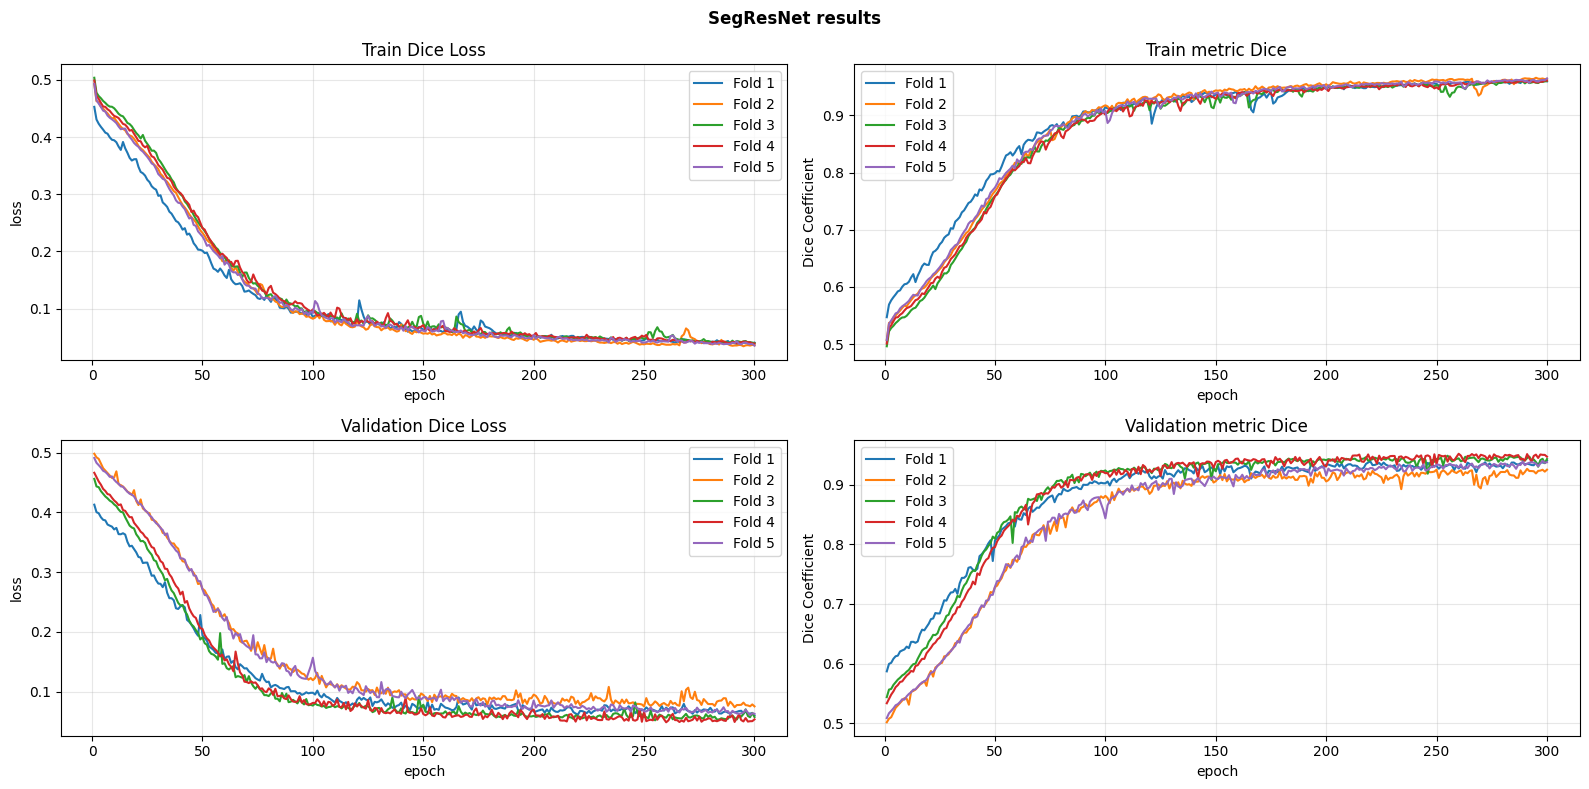

In [7]:
fig = plt.figure('Results', (16,8))
fig.suptitle('SegResNet results', fontweight = 'bold')
#fig.patch.set_visible(False)
plt.axis('off')
for i in range(5):
    plt.subplot(2,2,1)
    plt.title('Train Dice Loss')
    x = [i+1 for i in range(len(train_losses[0]))]
    y = train_losses[i]
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(x,y, label = f'Fold {i+1}')
    
    plt.subplot(2,2,2)
    plt.title('Train metric Dice')
    x = [i+1 for i in range(len(train_metrics[0]))]
    y = train_metrics[i]
    plt.xlabel('epoch')
    plt.ylabel('Dice Coefficient')
    plt.plot(x,y, label = f'Fold {i+1}')
    
    plt.subplot(2,2,3)
    plt.title('Validation Dice Loss')
    x = [i+1 for i in range(len(val_losses[0]))]
    y = val_losses[i]
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(x,y, label = f'Fold {i+1}')
    
    plt.subplot(2,2,4)
    plt.title('Validation metric Dice')
    x = [i+1 for i in range(len(val_metrics[0]))]
    y = val_metrics[i]
    plt.xlabel('epoch')
    plt.ylabel('Dice Coefficient')
    plt.plot(x,y, label = f'Fold {i+1}')

# Add legends and grid
for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.savefig(os.path.join(output_img_path,'SegResNet_results.png'), dpi=300)
plt.show()

In [8]:
# Print summary statistics
print("K-FOLD CROSS VALIDATION SUMMARY")
print('\nIndividual form performance')
best_dices = []
for idx, vm in enumerate(val_metrics):
    best_dice = vm.max()
    best_epoch = vm.argmax() + 1
    final_dice = vm[-1]
    mean_dice = vm.mean()
    std_dice = vm.std()

    best_dices.append(best_dice)

    print(f'Fold {idx+1}:')
    print(f'  Best Validation Dice:  {best_dice:.4f} at {best_epoch}')
    print(f'  Final Validation Dice: {final_dice:.4f}')
    print(f'  Mean across epochs:    {mean_dice:.4f} ± {std_dice:.4f}')
    print()
print('Overall performance')
mean_best_dice = np.mean(best_dices)
std_best_dice = np.std(best_dices)
min_best_dice = np.min(best_dices)
max_best_dice = np.max(best_dices)
print(f'Mean Best validation Dice: {mean_best_dice:.4f} ± {std_best_dice:.4f}')
print(f'best performing fold: fold {np.argmax(best_dices)+1} : ({max_best_dice:.4f})')
print(f'worst performing fold: fold {np.argmin(best_dices)+1} : ({min_best_dice:.4f})')

K-FOLD CROSS VALIDATION SUMMARY

Individual form performance
Fold 1:
  Best Validation Dice:  0.9400 at 300
  Final Validation Dice: 0.9400
  Mean across epochs:    0.8789 ± 0.0894

Fold 2:
  Best Validation Dice:  0.9263 at 291
  Final Validation Dice: 0.9248
  Mean across epochs:    0.8453 ± 0.1157

Fold 3:
  Best Validation Dice:  0.9483 at 255
  Final Validation Dice: 0.9427
  Mean across epochs:    0.8842 ± 0.1032

Fold 4:
  Best Validation Dice:  0.9515 at 260
  Final Validation Dice: 0.9466
  Mean across epochs:    0.8824 ± 0.1087

Fold 5:
  Best Validation Dice:  0.9395 at 298
  Final Validation Dice: 0.9373
  Mean across epochs:    0.8516 ± 0.1183

Overall performance
Mean Best validation Dice: 0.9411 ± 0.0088
best performing fold: fold 4 : (0.9515)
worst performing fold: fold 2 : (0.9263)


In [9]:
train_imgs = sorted(glob(os.path.join(in_path, 'imagesTr', '*.nii.gz')))
train_lbls = sorted(glob(os.path.join(in_path, 'labelsTr', '*.nii.gz')))
test_imgs =  sorted(glob(os.path.join(in_path, 'imagesTs', '*.nii.gz')))

train_files = [{"image": img, "label": lbl} for img, lbl in zip(train_imgs, train_lbls)]
test_files = [{"image": img} for img in test_imgs]
#test_files = test_files[0:9]

In [10]:
pixdim=(1.5, 1.5, 4.0)
a_min=0.0 
a_max=1448.00
spatial_size=[128, 128,16]

# Testing transformation use EXCLUSIVELY the basic transform, we have only images 
test_transforms = Compose(
[
    LoadImaged(keys = 'image', reader=NibabelReader()), 

    EnsureChannelFirstd(keys = 'image'),
    Spacingd(keys = 'image', pixdim = pixdim, mode = 'bilinear' ),
    Orientationd(keys = 'image', axcodes = 'RAS'),
    ScaleIntensityRanged(keys = 'image', a_min = a_min , a_max = a_max, b_min=0.0, b_max=1.0, clip=True), # scaling the intensity apply it only on the image
    CropForegroundd(keys = 'image', source_key = 'image'), # need to specifiy which one is the image
    Resized(keys = 'image', spatial_size = spatial_size),
    
    ToTensord(keys = 'image')
]
)


In [11]:
test_ds = Dataset(data = test_files, transform = test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)


Making predictions on test set...
processing test case 1/16


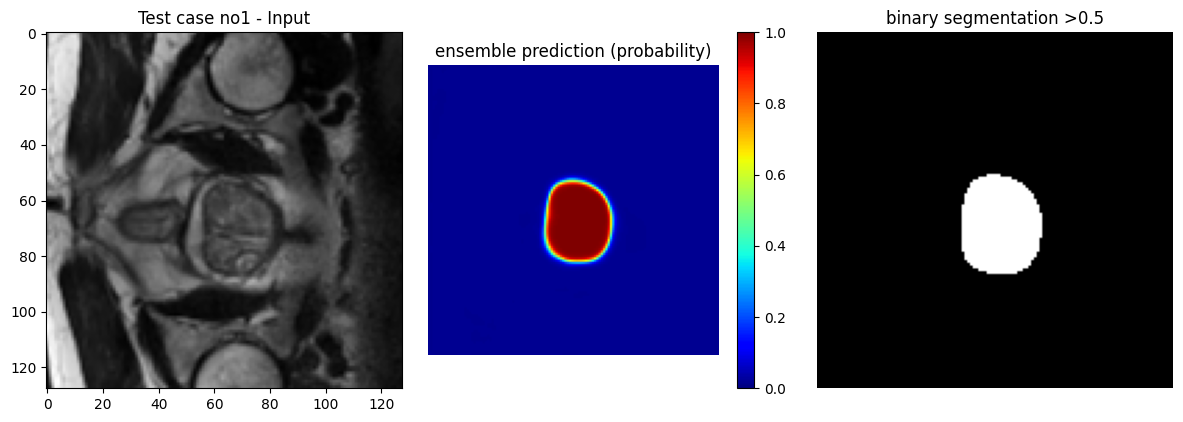

processing test case 2/16


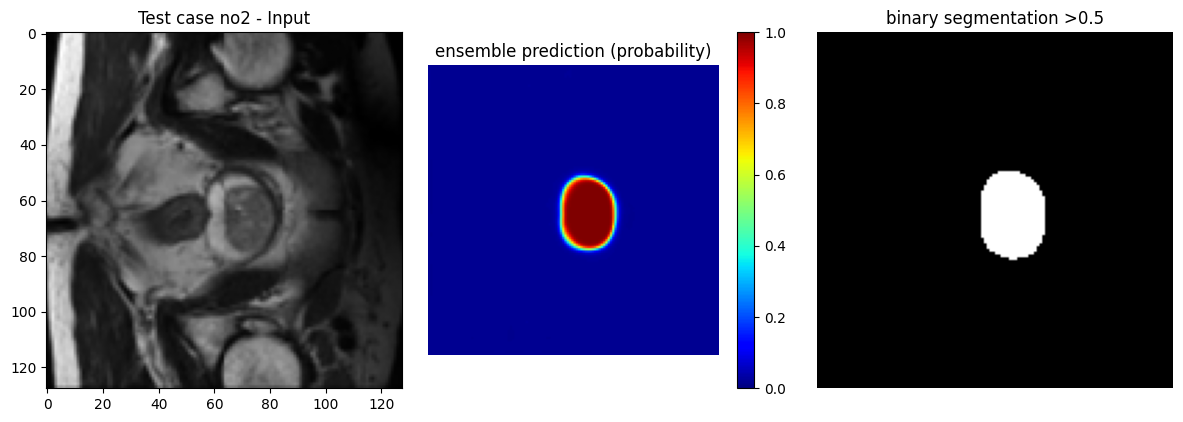

processing test case 3/16


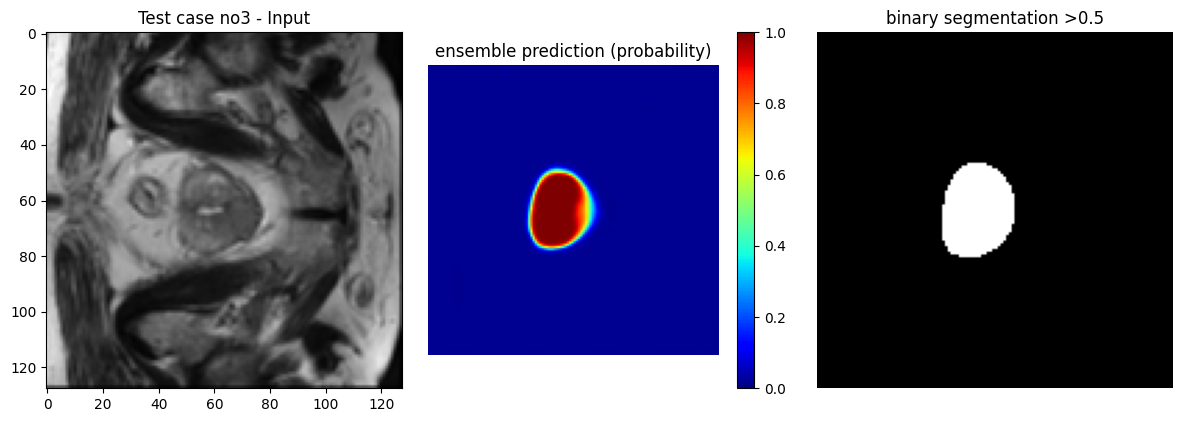

processing test case 4/16


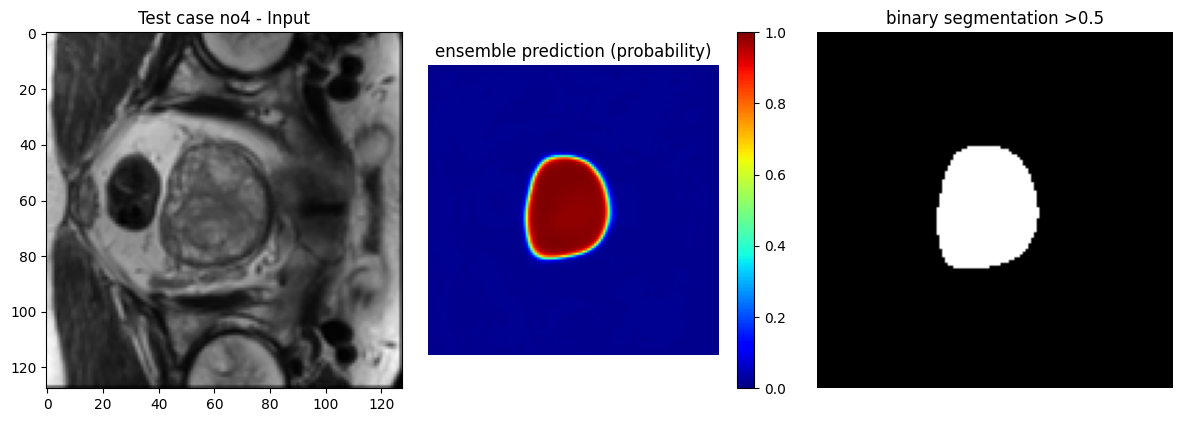

processing test case 5/16
processing test case 6/16
processing test case 7/16
processing test case 8/16
processing test case 9/16
processing test case 10/16
processing test case 11/16
processing test case 12/16
processing test case 13/16
processing test case 14/16
processing test case 15/16
processing test case 16/16
generated 16 predictions


In [12]:
# Make predictions
print("\nMaking predictions on test set...")
all_predictions = []

for idx, test_data in enumerate(test_loader):
    print(f'processing test case {idx+1}/{len(test_loader)}')
    volume = test_data['image'].to(device)

    ensemble_prediction = ensemble.predict(volume)

    all_predictions.append(ensemble_prediction.cpu().numpy())

    if idx <= 3:
        slice_idx = ensemble_prediction.shape[-1] // 2
        plt.figure('ensemble pred', (12,4))

        plt.subplot(1,3,1)
        plt.imshow(volume[0,0,:,:,slice_idx].cpu(), cmap= 'gray')
        plt.title(f'Test case no{idx+1} - Input')

        # foreground probability (remember [batch_size, channel, width, height, slice]
        plt.subplot(1,3,2)
        plt.imshow(ensemble_prediction[0,1,:,:,slice_idx].cpu(), cmap = 'jet', vmin=0, vmax=1)
        plt.title('ensemble prediction (probability)')
        plt.colorbar()
        plt.axis('off')

        # binary segmentation
        plt.subplot(1,3,3)
        binary_seg = (ensemble_prediction[0,1,:,:,slice_idx] > 0.5).float().cpu()
        plt.imshow(binary_seg, cmap='gray')
        plt.title('binary segmentation >0.5')
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(os.path.join(output_img_path,f'SegResNet_Test_segmentation_{idx+1}.png'), dpi=300)
        plt.show()

print(f'generated {len(all_predictions)} predictions')